In [58]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import typing

In [59]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]


Saving boat.jpg to boat (4).jpg


# Part 1 Quantization

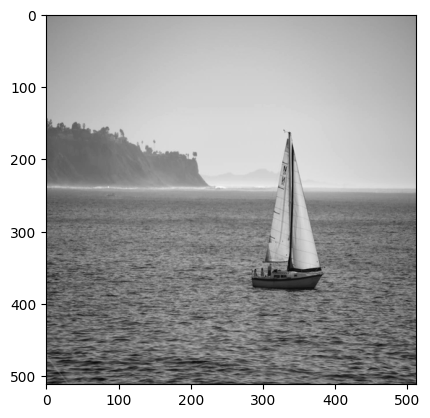

In [60]:
# Open image as gray scale
image = Image.open(filename).convert('L')  # Convert to grayscale
image = image.resize((512,512))
plt.imshow(image, cmap='gray')
plt.show()


**(Q1)** Question: We would like to estimate the probability density function (pdf) of the gray levelsin the image using the image histogram. If the histogram seems too uniform, please pick another image with a non-uniform distribution.

**Solution** :  We calculated the histogram of the gray-scale pixels and estimated the distribution by normalizing the histogram with the total number of pixels.

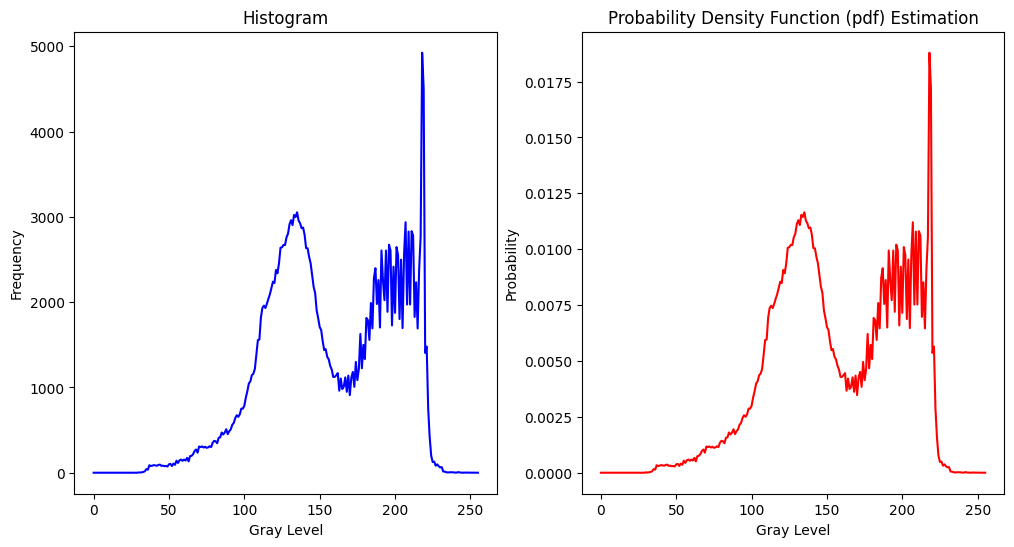

In [61]:
hist= np.array(image.histogram())
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram
axes[0].plot(hist, color='blue')
axes[0].set_title('Histogram')
axes[0].set_xlabel('Gray Level')
axes[0].set_ylabel('Frequency')

# Calculate the PDF
pdf = hist / np.sum(hist)
# Plot pdf
axes[1].plot(pdf, color='red')
axes[1].set_title('Probability Density Function (pdf) Estimation')
axes[1].set_xlabel('Gray Level')
axes[1].set_ylabel('Probability')
a = np.array(image)

plt.show()

**(Q2)** Apply uniform quantization on the image using b bits per pixel.

**(a)** Show the MSE as a function of the bit-budget b for b = 1, ..., 8

**(b)** Plot the decision and representation levels for representative b values.


In [66]:
def uniform_quantization_image(image: Image,b: int, low: int,high: int,
                               is_high_included: bool):
  n_representaion_levels = np.power(2, b)
  delta= (high -low) / n_representaion_levels

  # Perform uniform quantization using the formula from class
  quantized_image = low + (np.floor((image - low) / delta) + 0.5) * delta

  if is_high_included:
    # Handle the exact maximum value separately
    #(Because the formula isn't working when high value included)
    last_rep_level = low + (n_representaion_levels -0.5)*delta
    quantized_image[image == high] = last_rep_level

  unique_values = np.unique(quantized_image)  # Get unique quantized values
  return quantized_image


def uniform_mse(image: np.ndarray, quantized_image: np.ndarray) -> float:
    return np.mean((image - quantized_image)**2)

def get_uniform_decision_levels_and_representation_levels(b: int,
                                                          low: int,
                                                          high: int):
    n_representation_levels = np.power(2, b)
    decision_levels = np.linspace(low, high, n_representation_levels + 1)
    representation_levels = (decision_levels[:-1] + decision_levels[1:]) / 2
    return decision_levels, representation_levels

def plot_levels(b: int, low: int, high:int, decision_levels: np.ndarray,
                representation_levels: np.ndarray, method_name: str):
    x = np.linspace(low, high, 1000)

    plt.figure(figsize=(10, 6))

    # Plot y=x line
    plt.plot(x, x, 'k--', label='$y=x$', zorder=1)

    # Plot decision levels on x-axis
    plt.scatter(decision_levels, [0] * len(decision_levels),
                color='red', zorder=3, marker='|', label = "Decision Levels")

    # Plot representation levels on y=x line
    plt.scatter(representation_levels, [0] * len(representation_levels),
                color='blue', zorder=3, label = "Representation Levels",
                marker=".")

     # Create the step function
    for i in range(len(decision_levels) - 1):
        plt.hlines(representation_levels[i], decision_levels[i],
                   decision_levels[i+1], colors='blue', lw=2)

    for r in representation_levels:
      plt.vlines(r, 0, r, color='blue', linestyle='dotted', zorder=1)
      plt.hlines(r, 0, r, color='blue', linestyle='dotted', zorder=1)

    plt.title(f'{method_name}- Decision levels and representation levels for {b} Bits')
    plt.xlabel('x')
    plt.ylabel('Q(x)')
    plt.grid(True)
    plt.legend()
    plt.show()



**Solution for 2a**: calculating uniform quantization

[1443.788803100586, 392.9561023712158, 83.38218438625336, 20.76272252202034, 5.119797915220261, 1.292194902896881, 0.2889904282055795, 0.039533190545625985]


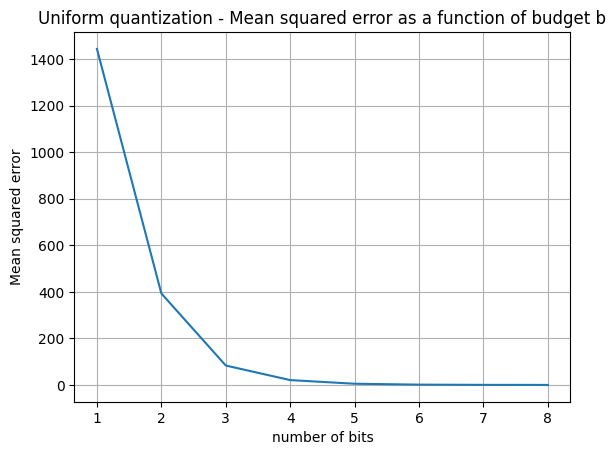

In [67]:
numpy_image = np.array(image)
mse_scores_uniform = []
for i in range(1,9):
  quantized_image = uniform_quantization_image(numpy_image, b=i, low = 0,
                                               high=255, is_high_included=True)
  mse = uniform_mse(numpy_image, quantized_image)
  mse_scores_uniform.append(mse)


print(mse_scores_uniform)
plt.plot(range(1,9), mse_scores_uniform)
plt.title("Uniform quantization - Mean squared error as a function of budget b")
plt.xlabel("number of bits")
plt.ylabel("Mean squared error")
plt.grid()

**Solution for 2b: ploting the decision levels and represnation levels as in tutorials**

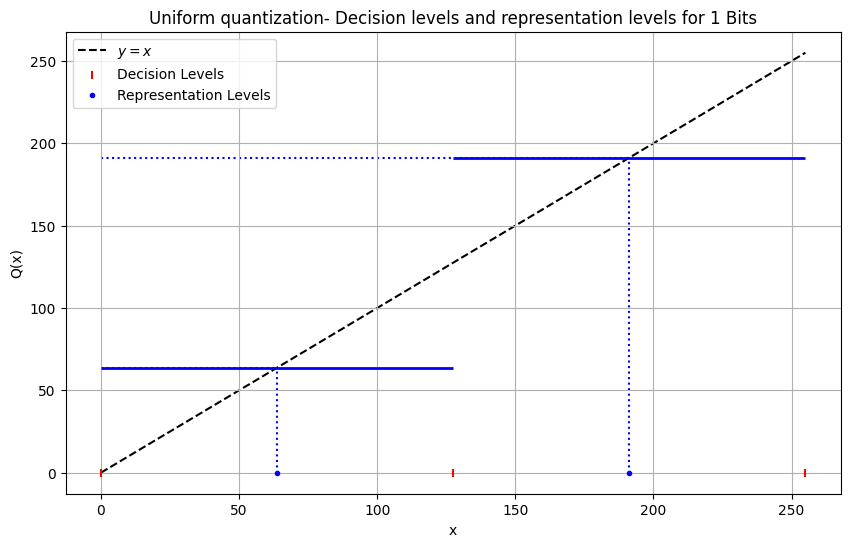

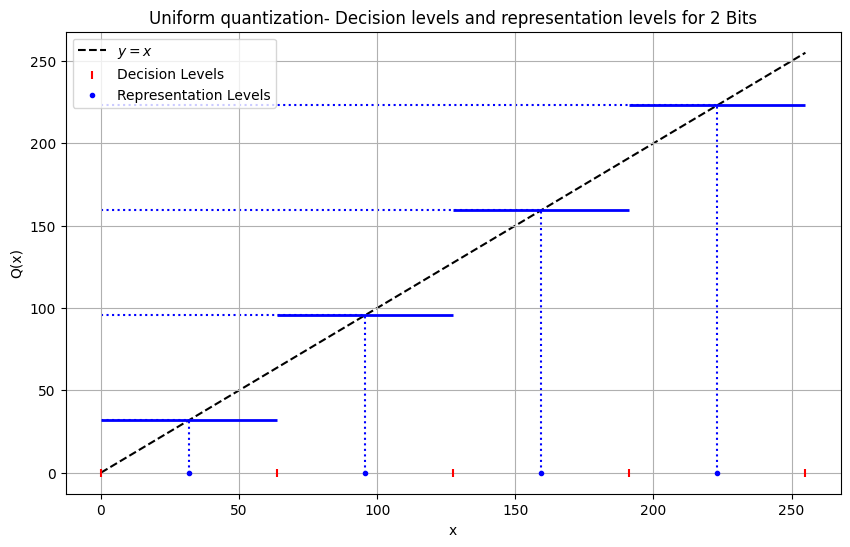

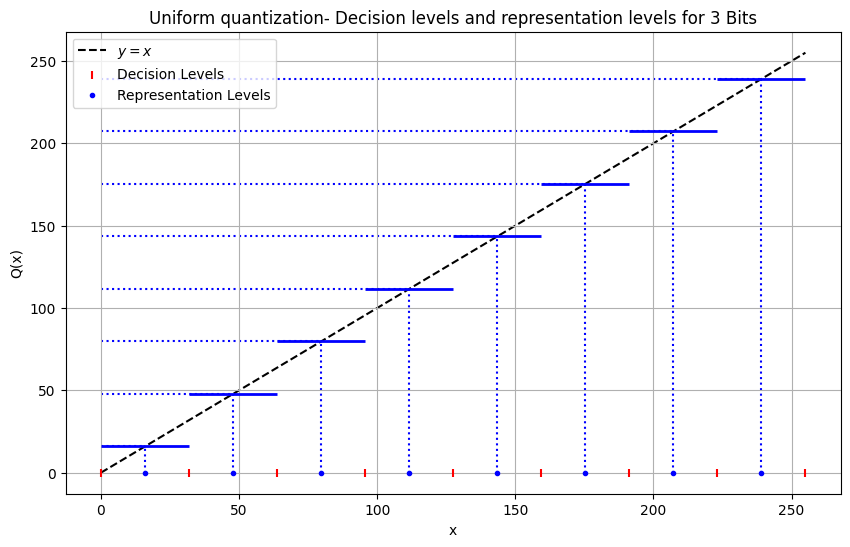

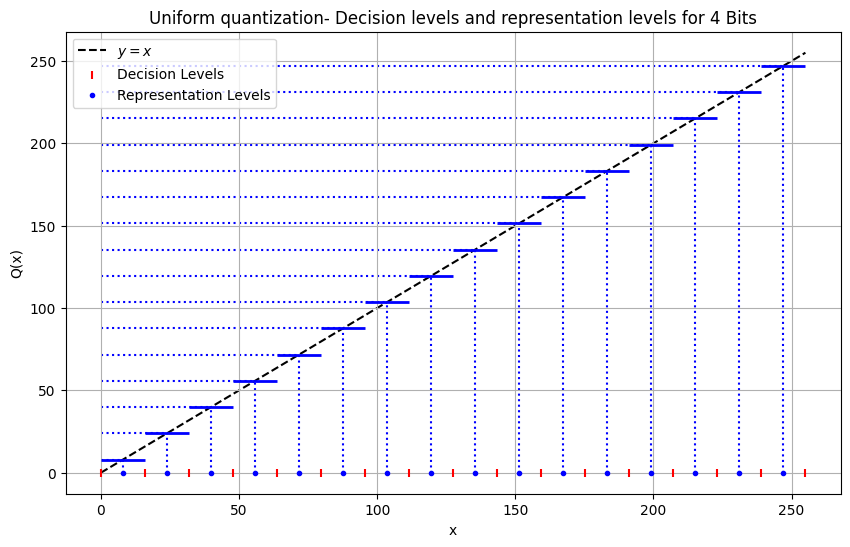

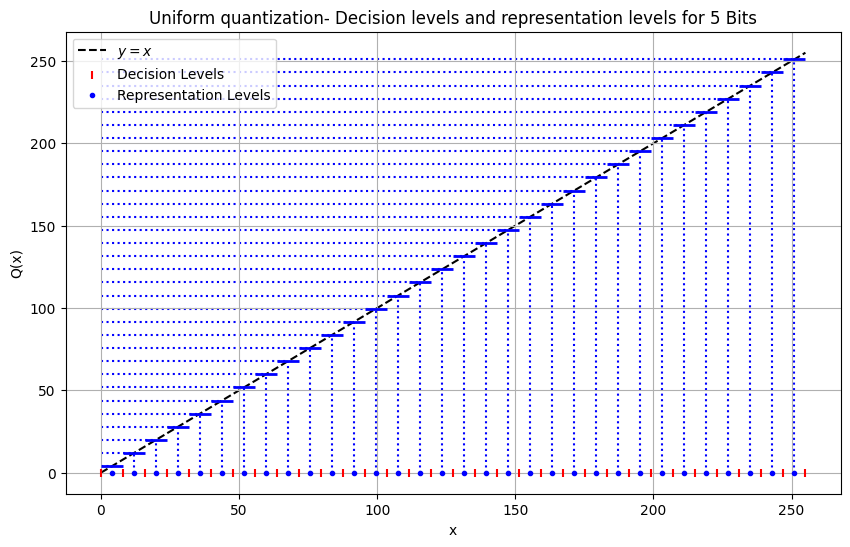

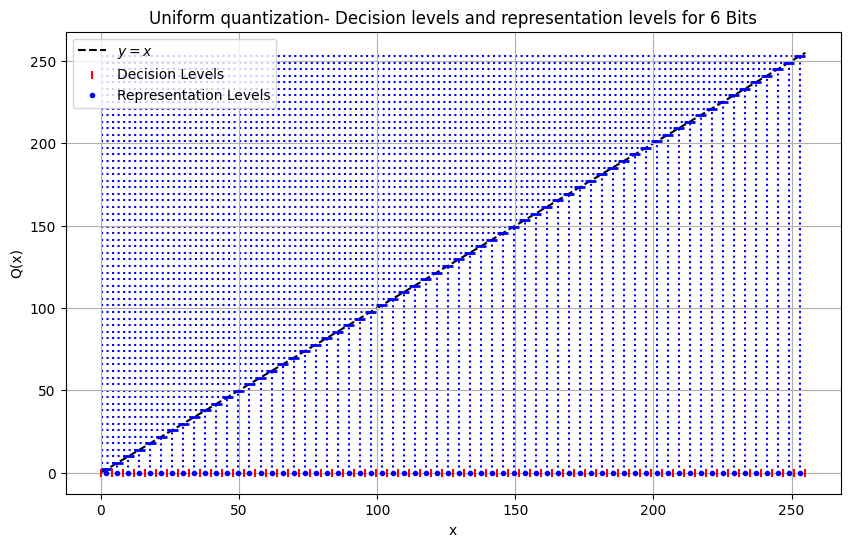

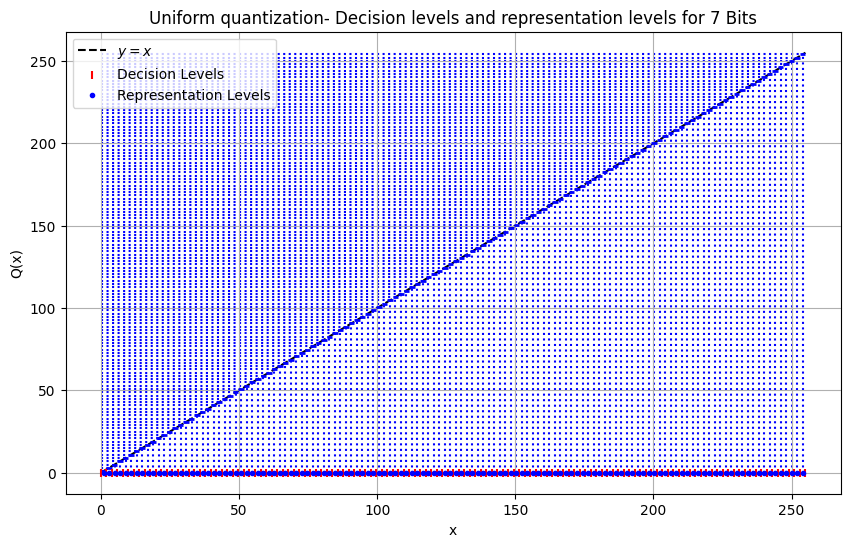

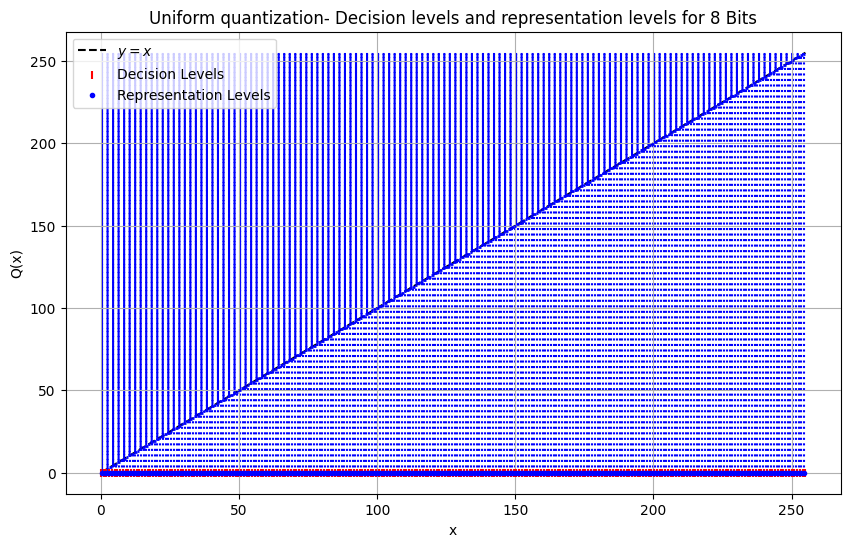

In [74]:
for i in range(1,9):
    decision_levels, representation_levels = \
        get_uniform_decision_levels_and_representation_levels(i, 0, 255)

    plot_levels(i, 0, 255, decision_levels, representation_levels,
                "Uniform quantization")

**(Q3)**
Implement the Max-Lloyd algorithm. This should be a function taking as input
a histogram pdf, a vector of initial decision levels, and a small value ε > 0 for
convergence tolerance. The function should return the converged decision levels and
the converged representation levels. In order to handle numerical approximations,
we use ε as a stopping condition: when the MSE improves by less than ε we stop the
algorithm.

In [79]:
#for k repersentation levels we have: k itervals, k+1 decision levels
#where we need to calc only k-1
def calc_optimal_represenation_levels(pdf: np.ndarray,
                                      decision_levels: np.ndarray)->np.ndarray:
  # Calculate the optimal representation levels (r_i)
  #for each interval given the decision levels (d_i).
  x = np.arange(0, 256)
  representation_levels = []
  for i in range(1, len(decision_levels)):
    mask = 0
    if i == 1:
      mask = (x <= decision_levels[i])
    else:
      mask = (x > decision_levels[i-1]) & (x <= decision_levels[i])
    weighted_sum_i = np.dot(x[mask], pdf[mask])
    total_weights = np.sum(pdf[mask])

    if(total_weights != 0):
      representation_levels.append(weighted_sum_i / total_weights)
    else:
       #In the case of 0 probability ignore the interval
       representation_levels.append(None)
  return np.array(representation_levels)


def calc_optimal_decision_levels(representation_levels: np.ndarray, d_0: float,
                                 d_last:float) -> np.ndarray:
  #Calculate the optimal decision levels (d_i)
  # as the midpoint between adjacent representation levels (r_i).
  decision_levels = (representation_levels[:-1] + representation_levels[1:]) / 2
  # Add the first and last decision levels
  decision_levels = np.insert(decision_levels, 0, 0)
  decision_levels = np.append(decision_levels, 255)
  return decision_levels


def weighted_mse(pdf: np.ndarray, decision_levels: np.ndarray,
                 representation_levels: np.ndarray) -> float:
  # Calculate the mean squared error (MSE) for the given quantization.
    x = np.arange(256)
    mse = 0
    for i in range(1, len(decision_levels)):
        if i == 1:
            mask = (x <= decision_levels[i])
        else:
            mask = (x > decision_levels[i-1]) & (x <= decision_levels[i])

        error = (x[mask] - representation_levels[i-1]) ** 2
        mse += np.dot(error, pdf[mask])
    return mse

def lloyd_max(pdf: np.ndarray, initial_decision_levels: np.ndarray,
              epsilon: float) -> typing.Tuple[np.ndarray, np.ndarray]:

    decision_levels = initial_decision_levels
    representation_levels = None
    prev_mse = np.inf
    while True:
        # Calculate the representation levels
        representation_levels = \
        calc_optimal_represenation_levels(pdf,decision_levels)
        #fuse the empty interval with another,
        representation_levels = \
        representation_levels[representation_levels != None]
        # Calculate the new decision levels
        decision_levels = \
        calc_optimal_decision_levels(representation_levels,
                                     decision_levels[0], decision_levels[-1])

        # Calculate MSE using the provided formula
        assert(decision_levels.size == representation_levels.size +1)
        mse = weighted_mse(pdf, decision_levels, representation_levels)

        # Check for convergence
        if np.abs(prev_mse-mse) < epsilon:
            break
        prev_mse = mse

    return decision_levels, representation_levels, mse


**(Q4) Apply the Max-Lloyd quantizer starting with uniform quantization**

**(a) Show the MSE as a function of the bit-budget b for b = 1, ..., 8.**

[408.93446754242274, 143.42688667957012, 36.33205956824455, 13.88497344982863, 4.849251580179066, 1.2358923350904383, 0.24796862228892771, 0.0]


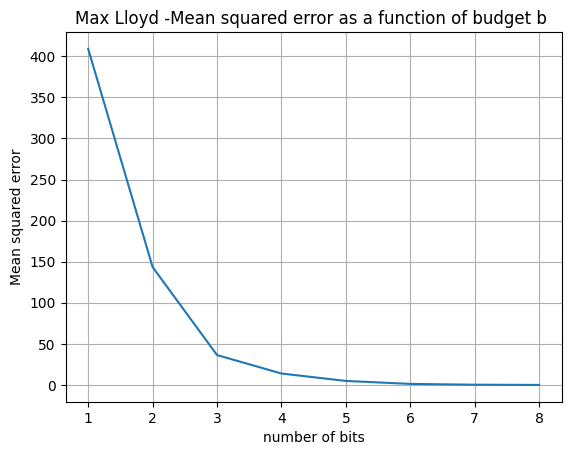

In [81]:
mse_scores_lloyd = []
epsilon = 1e-5
for i in range(1,9):
  uniform_d, _= \
  get_uniform_decision_levels_and_representation_levels(i, 0, 255)

  decision_levels, representation_levels, mse = lloyd_max(pdf, uniform_d,
                                                          epsilon)
  mse_scores_lloyd.append(mse)


print(mse_scores_lloyd)
plt.plot(range(1,9), mse_scores_lloyd)
plt.title("Max Lloyd -Mean squared error as a function of budget b ")
plt.xlabel("number of bits")
plt.ylabel("Mean squared error")
plt.grid()

**(b) Plot the decision and representation levels for representative b values**

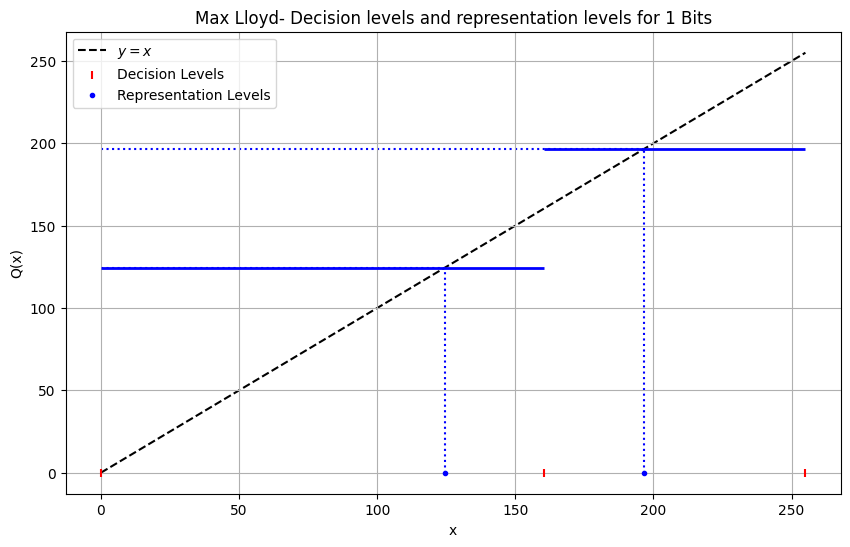

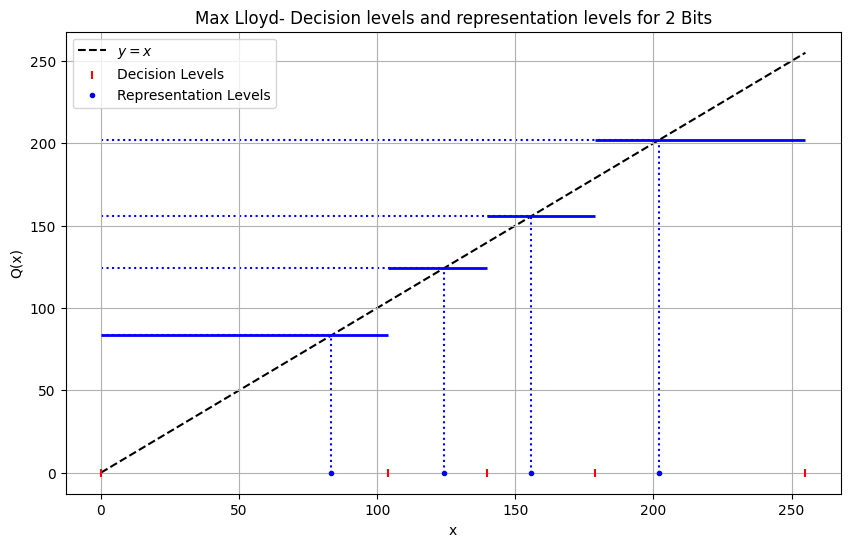

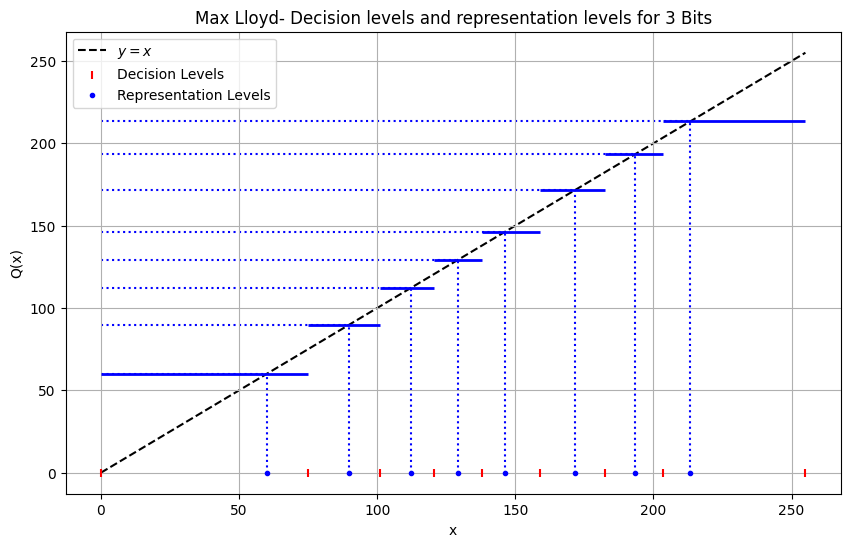

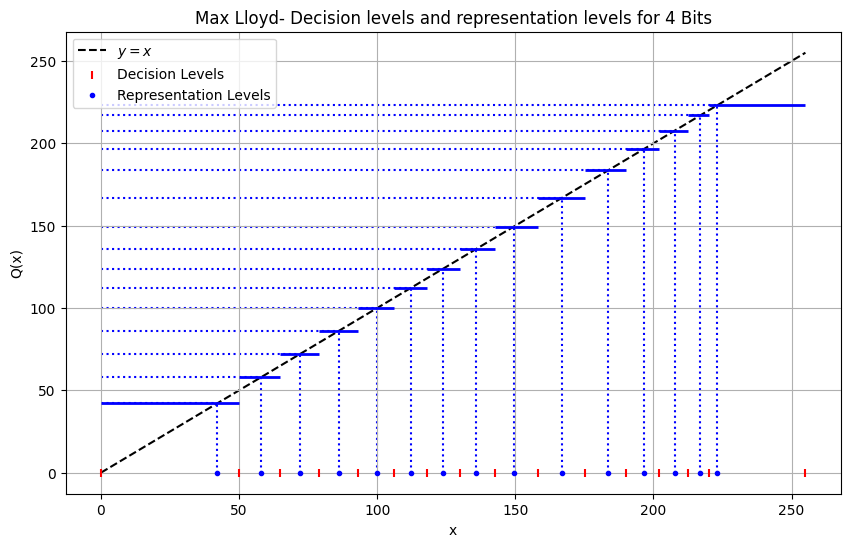

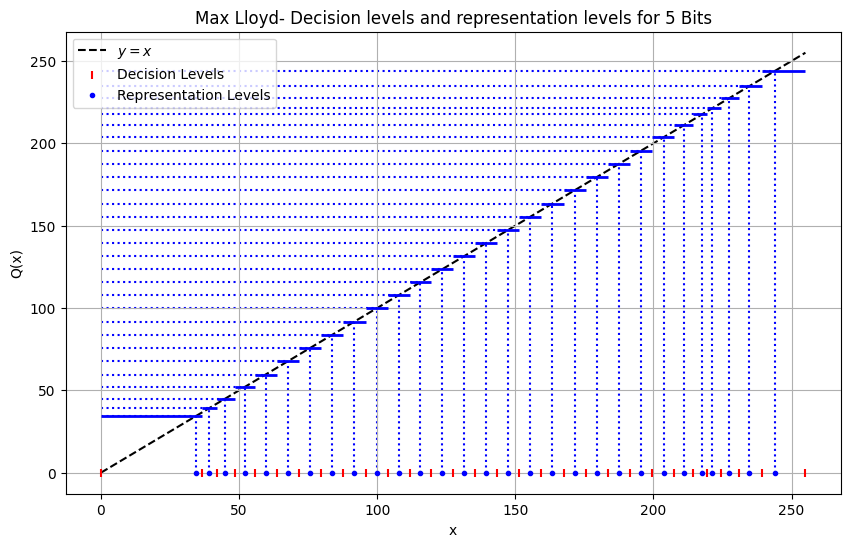

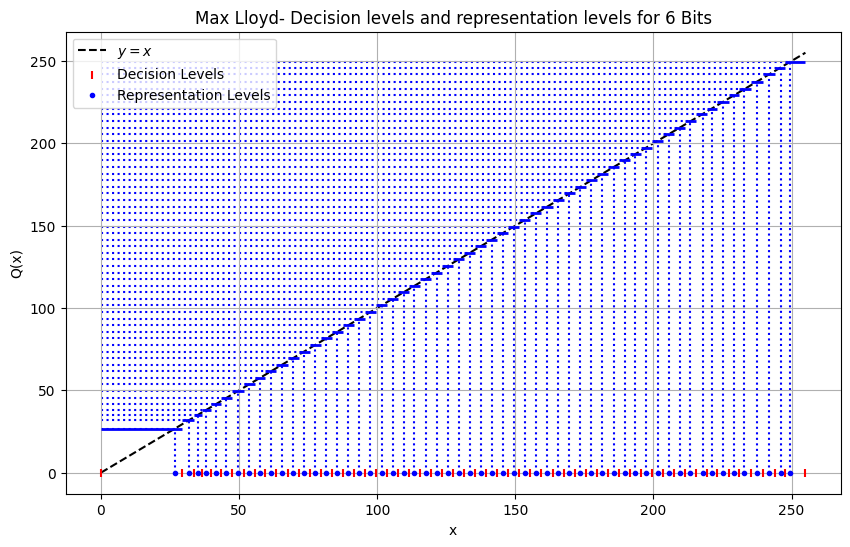

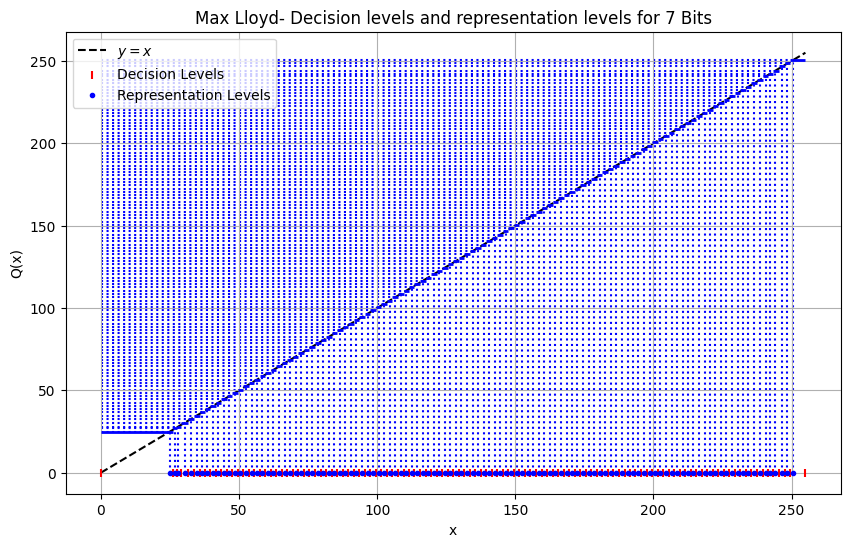

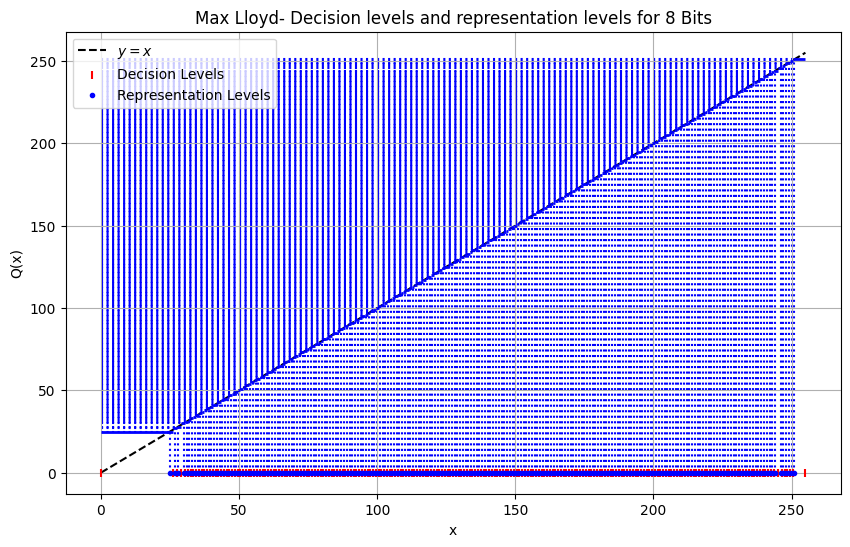

In [82]:
for i in range(1,9):
  uniform_d, _= get_uniform_decision_levels_and_representation_levels(i, 0, 255)
  decision_levels, representation_levels, mse = lloyd_max(pdf, uniform_d,
                                                          epsilon)

  plot_levels(i, 0, 255, decision_levels, representation_levels, "Max Lloyd")

**(c) Compare the results to those of the uniform quantizer. Explain the difference**

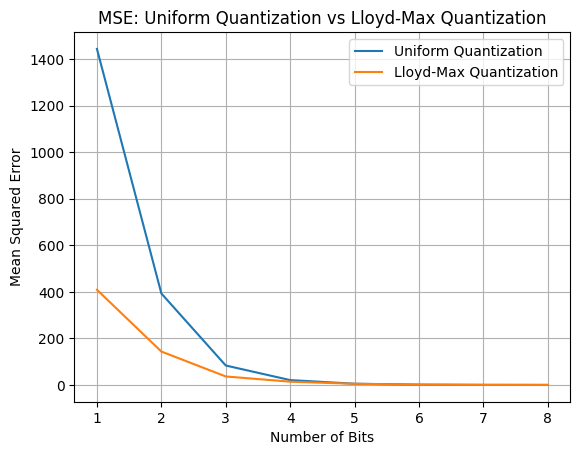

In [83]:
plt.plot(range(1, 9), mse_scores_uniform, label='Uniform Quantization')
plt.plot(range(1, 9), mse_scores_lloyd, label='Lloyd-Max Quantization')

plt.title("MSE: Uniform Quantization vs Lloyd-Max Quantization")
plt.xlabel("Number of Bits")
plt.ylabel("Mean Squared Error")

plt.grid()

plt.legend()

plt.show()

As shown in the graph, the Mean Squared Error (MSE) is consistently lower for Lloyd-Max quantization compared to uniform quantization, especially when we have a lower number of representation levels. This is because the Lloyd-Max algorithm considers the distribution of the random variable. When the distribution is not uniform, Lloyd-Max will return non-uniform decision levels, resulting in tighter decision levels where the distribution is denser, thereby minimizing the MSE.

Uniform quantization, on the other hand, always uses the same intervals, so it is less effective for non-uniform distributions.

When the number of bits increases, the MSE for both methods converges. This happens because with more bits, both quantization methods have finer intervals and more representation levels, making the differences smaller. When the number of representation levels matches the possible range of values, both methods will result in zero error.

# Part 2 : Subsampling and reconstruction

**(1)Consider an image as a discrete 2D sampled signal denoted as I(x, y), where x and y
are the position indices on the images. Crop or resize your image such that its number
of rows and columns are a power of 2 greater than 8. For integer sub-sampling factors
D = 21
, 2
2
, · · · , 2
8
, grid the image domain uniformly in x and y, giving Nx × Ny
uniform rectangular grid sample regions. Each region will be subsampled using a
unique optimal number in some sense.**

In [84]:
image_numpy = np.array(image)

print(image_numpy.shape)


(512, 512)


In [86]:
def subsample_image(image, factor, method="mean"):
    h, w = image.shape
    new_h, new_w = h // factor, w // factor
    subsampled_image = np.zeros((new_h, new_w))
    reconstructed_image = np.zeros((h, w))

    for i in range(new_h):
        for j in range(new_w):
            block = image[i*factor:(i+1)*factor, j*factor:(j+1)*factor]
            if method == "mean":
                subsampled_image[i, j] = np.mean(block)
            elif method == "median":
                subsampled_image[i, j] = np.median(block)
            else:
                raise ValueError("Invalid method")

            reconstructed_image[i*factor:(i+1)*factor, j*factor:(j+1)*factor]= \
            subsampled_image[i, j]

    return subsampled_image, reconstructed_image

def calculate_mad(original, reconstructed_image):

    return np.mean(np.abs(original - reconstructed_image))

def calculate_mse(original, reconstructed_image):
   return np.mean((original - reconstructed_image )**2)


**(a)In the MSE sense, present the sub-sampled image for all different D.
Show the MSE as a function of the integer
sub-sampling factor D**

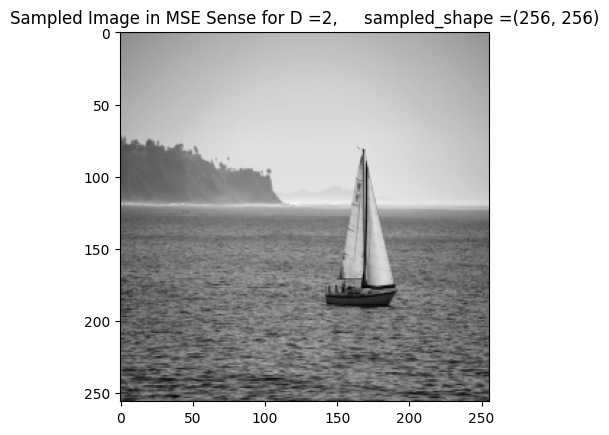

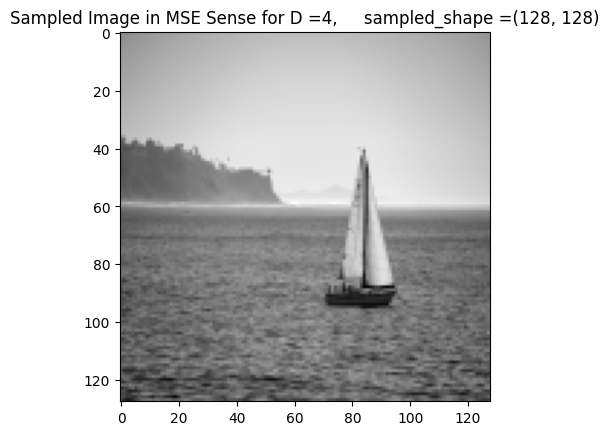

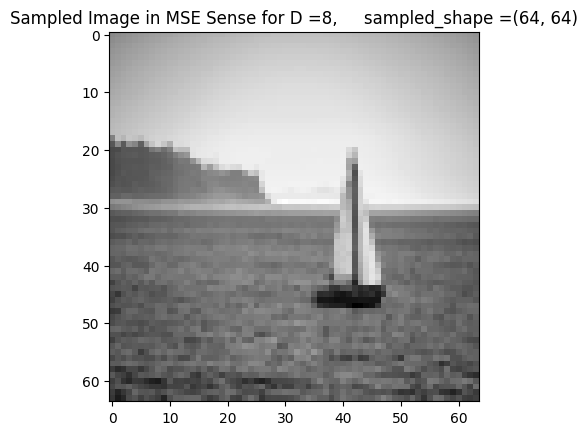

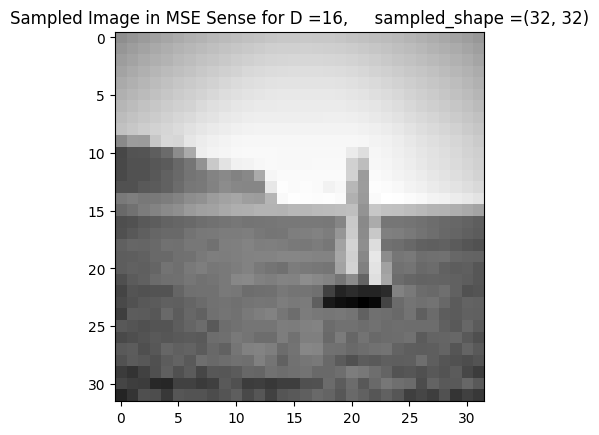

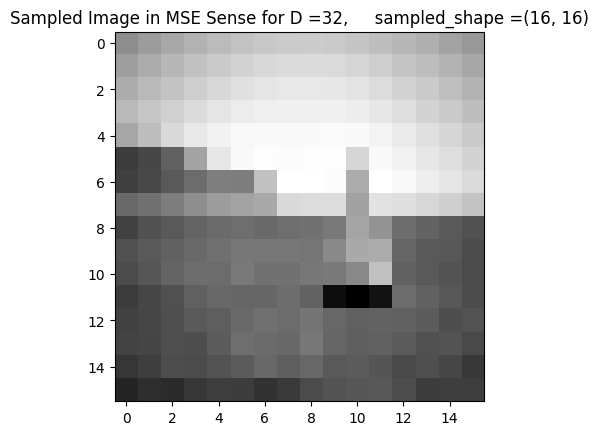

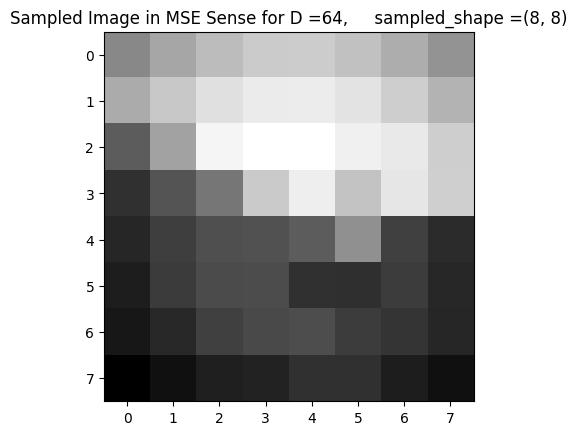

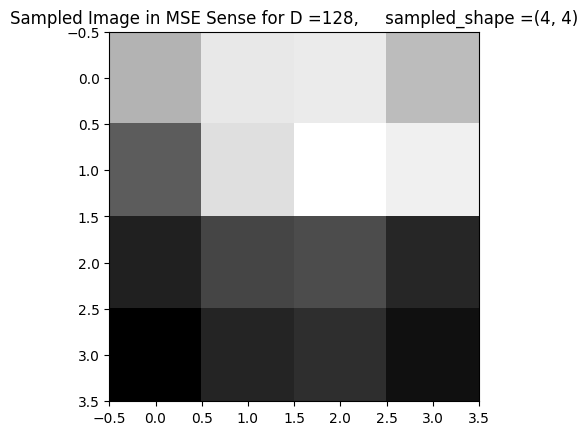

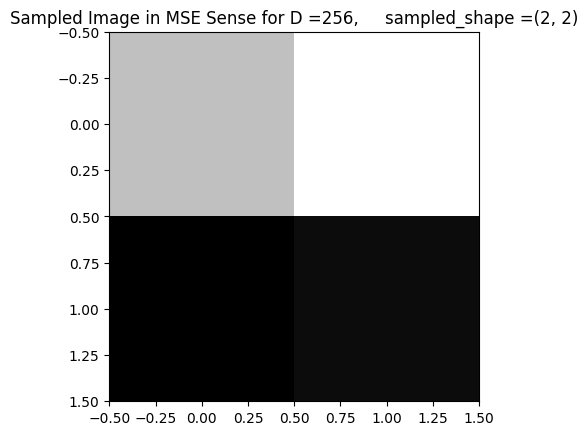

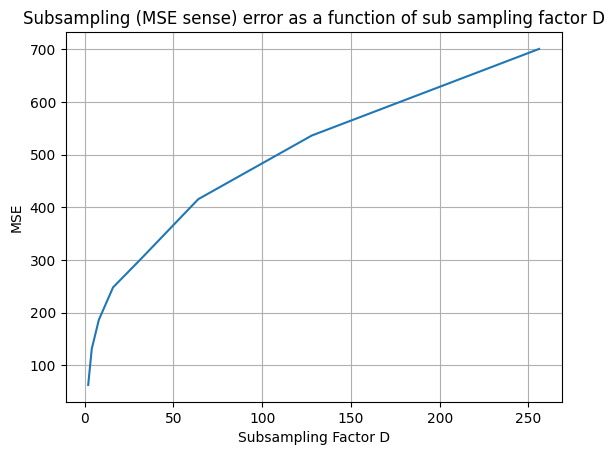

In [87]:
mse_arr = []
factors = [2**i for i in range(1, 9)]

for factor in factors:
    subsampled_img, reconstructed_img = subsample_image(image_numpy, factor,
                                                        method="mean")

    mse = calculate_mse(image_numpy, reconstructed_img)
    plt.imshow(subsampled_img, cmap='gray')
    plt.title(f"Sampled Image in MSE Sense for D ={factor}, \
    sampled_shape ={subsampled_img.shape}")
    plt.show()
    mse_arr.append(mse)

print ("")
# Plotting the MSE and MAD results
plt.plot(factors, mse_arr)
plt.title("Subsampling (MSE sense) error as a function of sub sampling factor D")
plt.xlabel("Subsampling Factor D")
plt.ylabel("MSE")
plt.grid()
plt.show()

**(b) In the MAD sense, present the sub-sampled image for all different D.  Show the MAD as a function of the
integer sub-sampling factor D.**

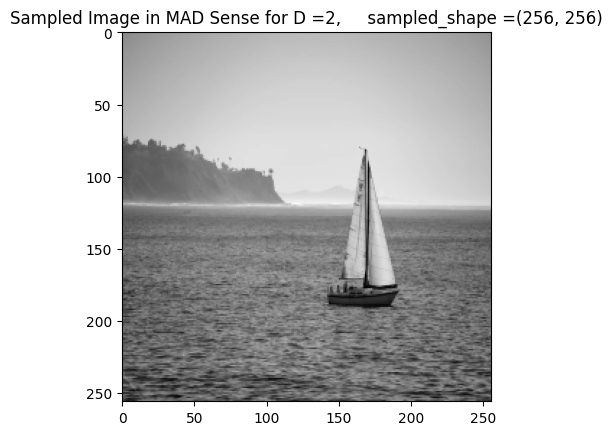

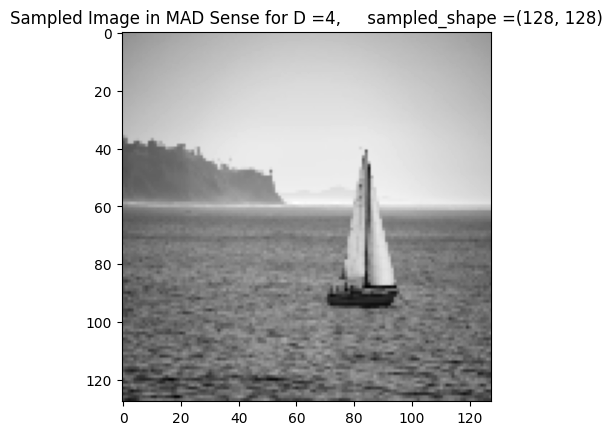

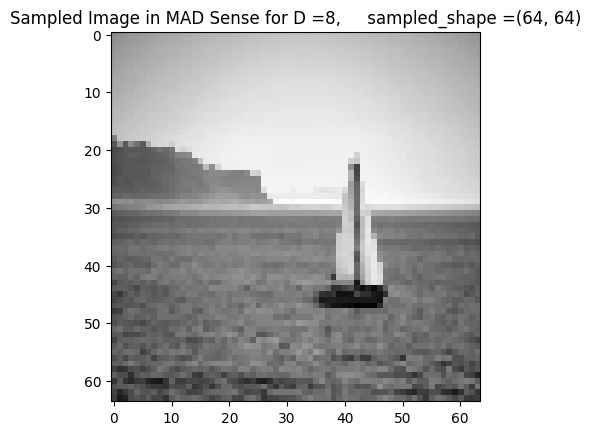

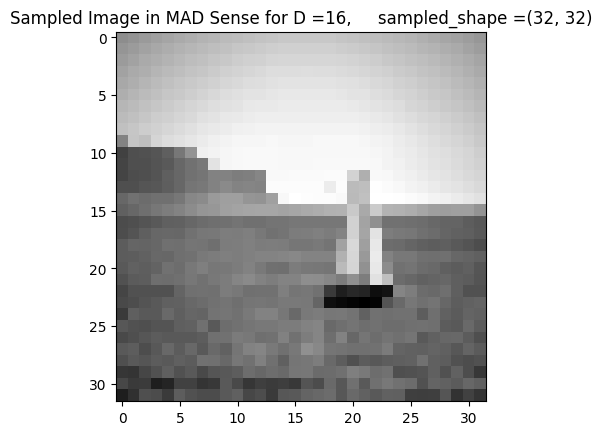

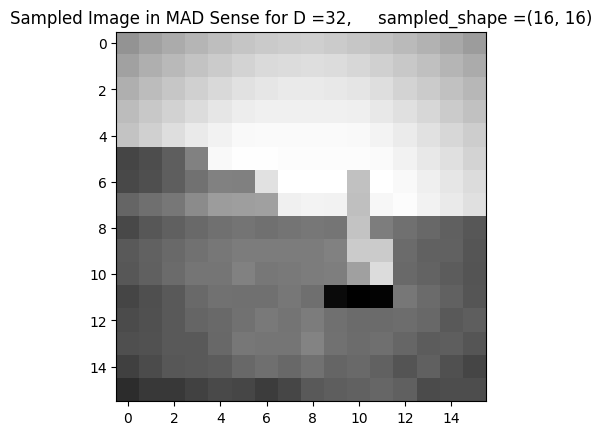

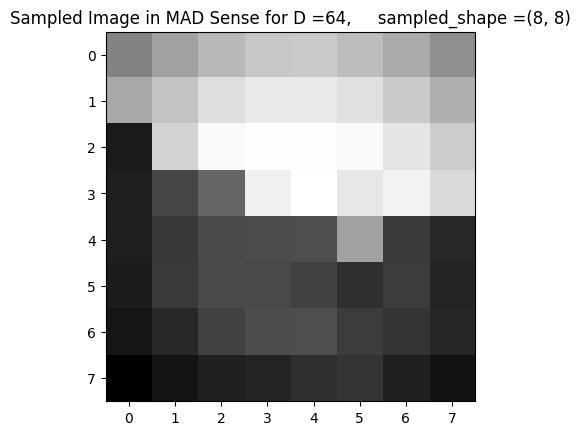

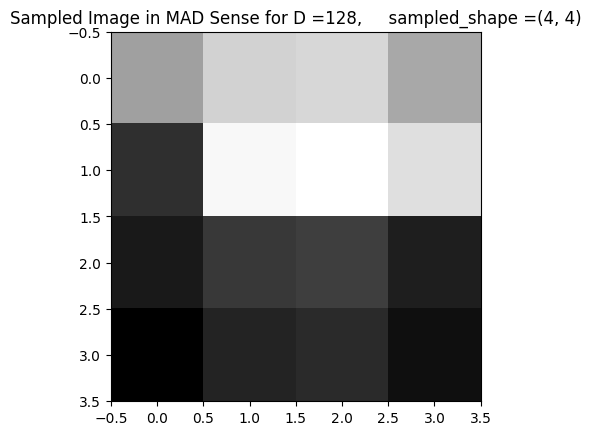

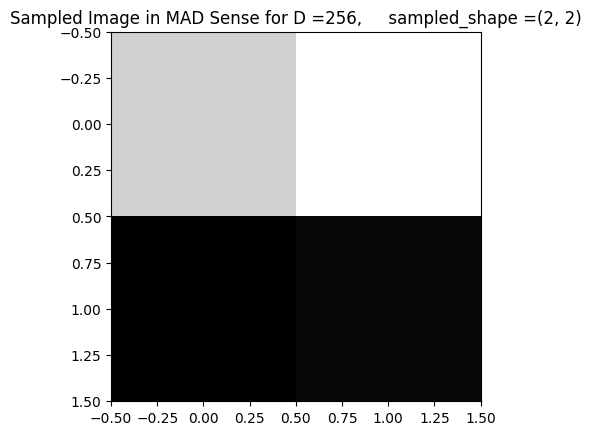

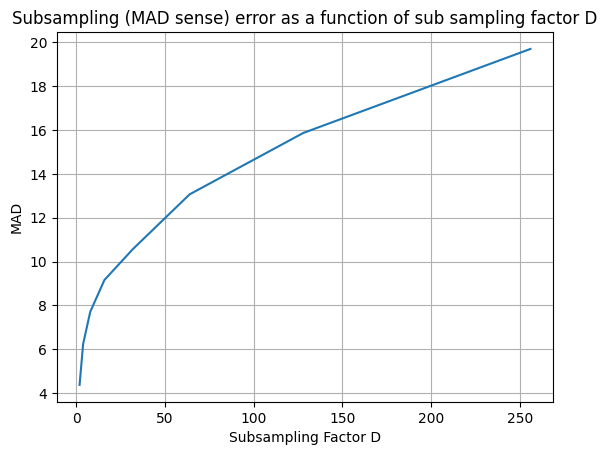

In [88]:
mad_arr = []
factors = [2**i for i in range(1, 9)]

for factor in factors:
    subsampled_img, reconstructed_img = subsample_image(image_numpy, factor,
                                                        method="median")
    plt.imshow(subsampled_img, cmap='gray')
    plt.title(f"Sampled Image in MAD Sense for D ={factor}, \
    sampled_shape ={subsampled_img.shape}")
    plt.show()
    mad = calculate_mad(image_numpy, reconstructed_img)
    mad_arr.append(mad)

# Plotting the MSE and MAD results
plt.plot(factors, mad_arr)
plt.title("Subsampling (MAD sense) error as a function of sub sampling factor D")
plt.xlabel("Subsampling Factor D")
plt.ylabel("MAD")
plt.grid()
plt.show()

**(Q2) Reconstructing the images**

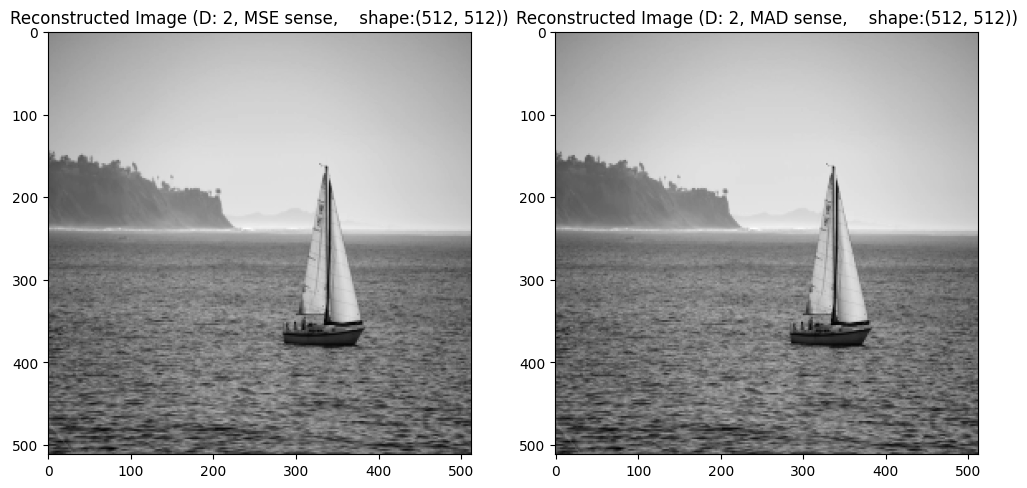

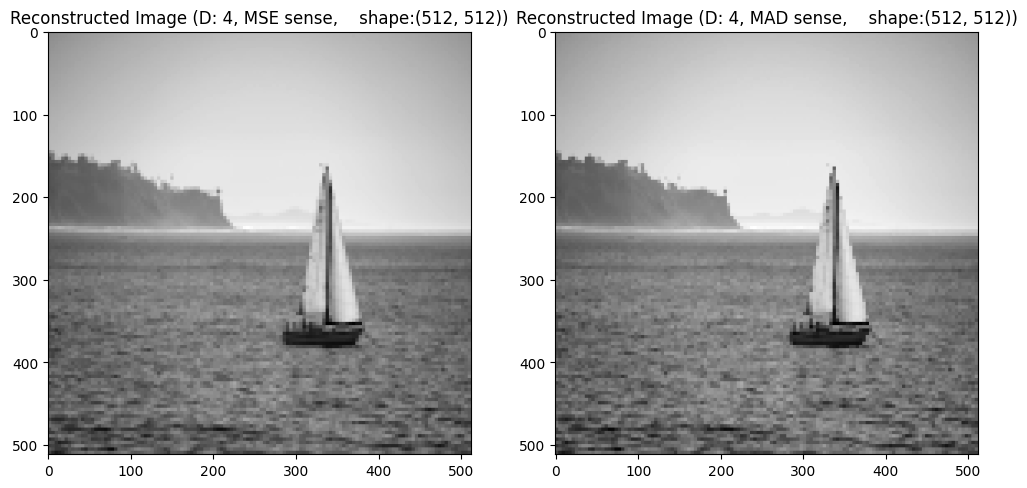

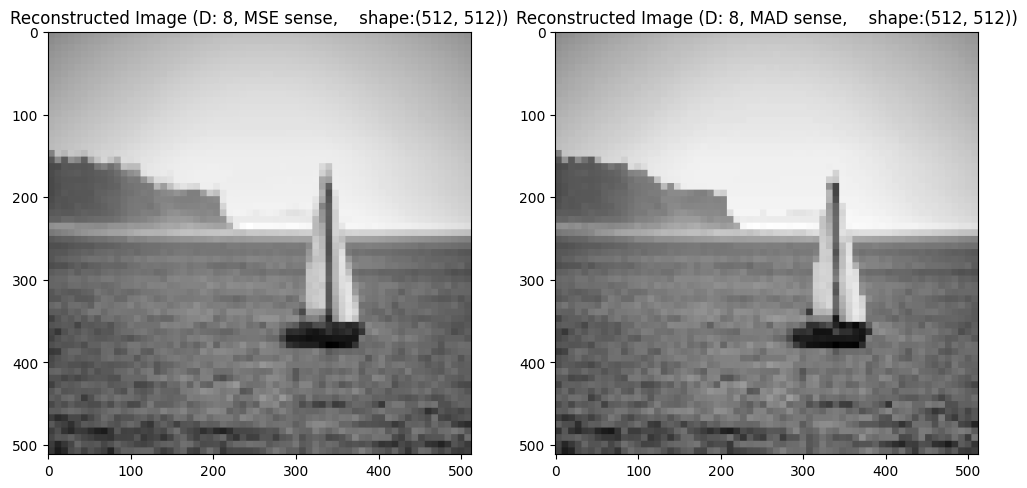

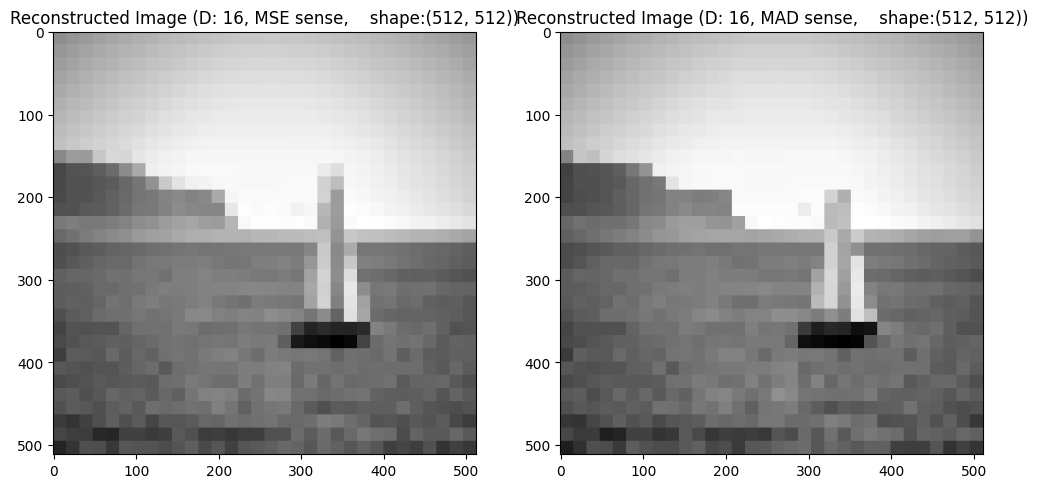

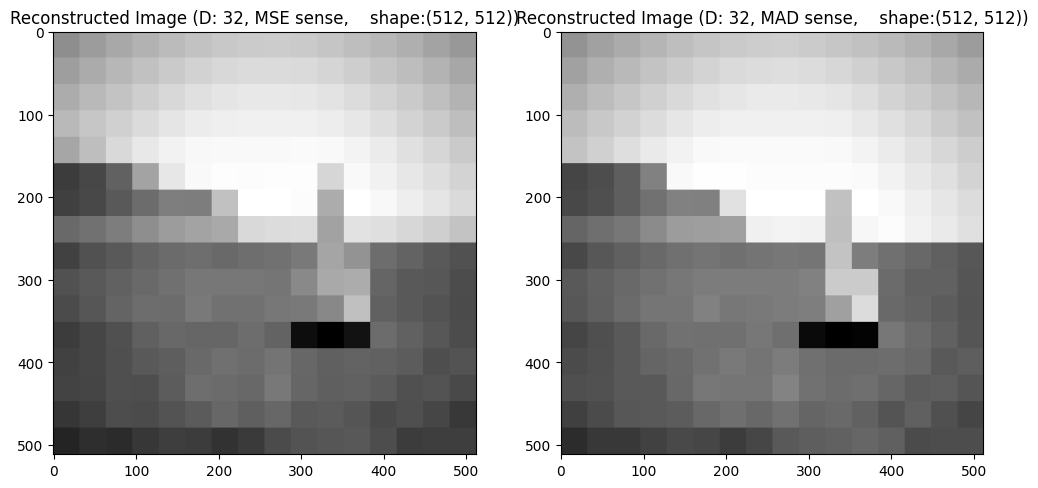

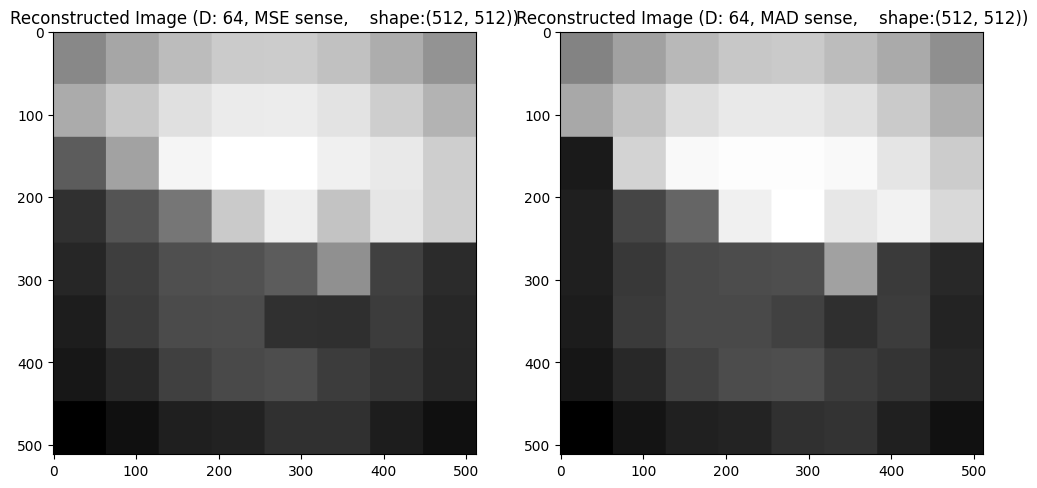

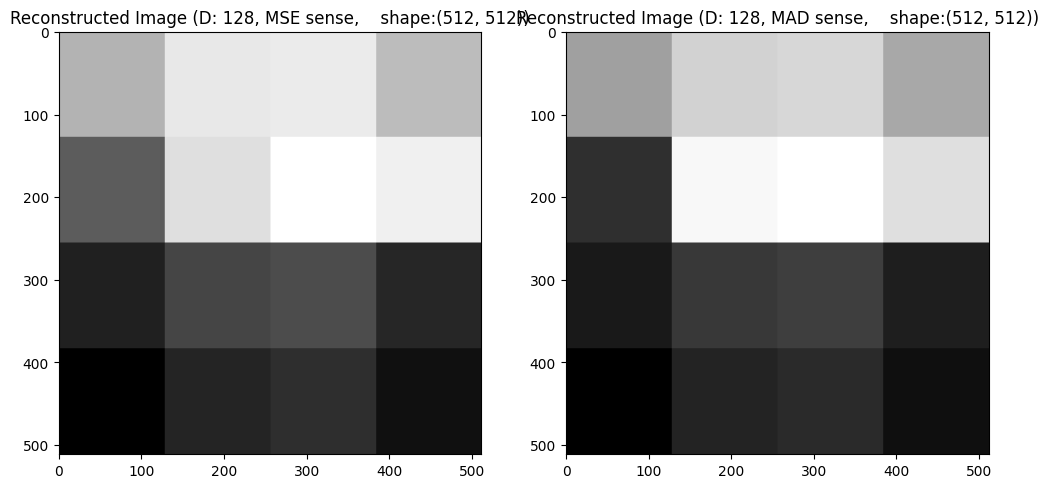

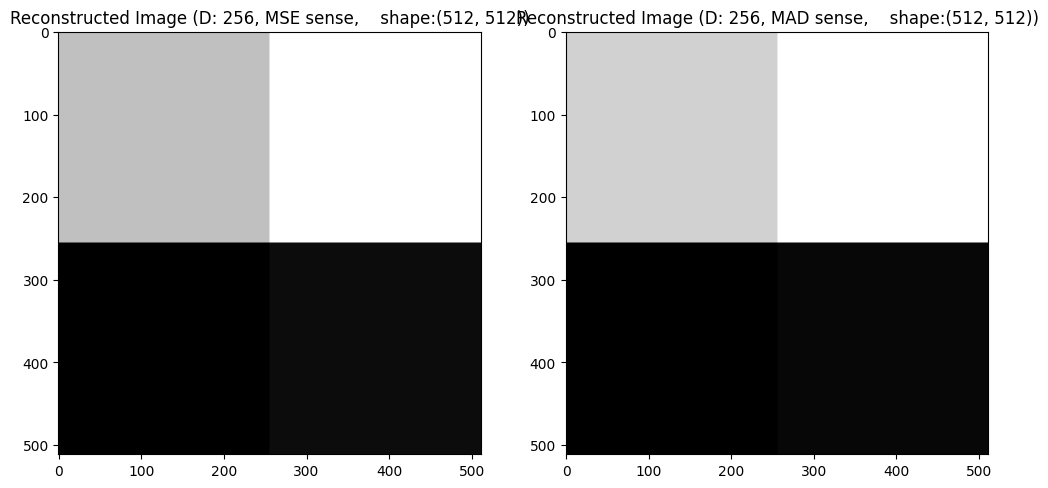

In [91]:
factors = [2**i for i in range(1, 9)]

for factor in factors:
    subsampled_img_mse, reconstructed_img_mse = subsample_image(image_numpy,
                                                                factor, method="mean")
    subsampled_img_mad, reconstructed_img_mad = subsample_image(image_numpy,
                                                                factor, method="median")
    # Create subplots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Reconstructed Image (D: {factor}, MSE sense,\
    shape:{reconstructed_img_mse.shape})")
    plt.imshow(reconstructed_img_mse, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title(f"Reconstructed Image (D: {factor}, MAD sense,\
    shape:{reconstructed_img_mse.shape})")
    plt.imshow(reconstructed_img_mad, cmap='gray')
    plt.show()


**(Q3)
Discuss how the integer sub-sampling factor D affects the result.**

**Solution**
When the subsampling factor D is small, the averages or medians are calculated over fewer pixels. This preserves more detail from the original image. As a result, the reconstructed image is closer to the original, leading to lower MSE and  MAD, as shown in the error graphs.

As D increases, the averages or medians are calculated over a larger number of pixels. This means losing more fine details, as the average or median over these larger grids smooths out the variations within each grid. Consequently, the subsampled image differs more from the original, resulting in higher MSE and MAD. These subsampled images appear blurrier and less detailed.

We also observe a difference between MAD optimal subsampling and MSE optimal subsampling in terms of the reconstructed photo. The reconstructed photo in the MSE sense usually looks smoother because it uses averages, which tend to blur the image more. In contrast, the reconstructed photo in the MAD sense, which uses medians, tends to preserve edges better and is less affected by outliers, making it less smooth but potentially more accurate in representing abrupt changes.

#Part 3: Solving the Lp problem using the L2 solution

**(1) Generalise and give without proof the pseudo-code of the approximate Lp solver using L2 solutions from exercise 1.f.**

**Algorithm 1- Solve Lp problem on a single grid:**

---



This algorithm get a function f and weights w restricted on a grid $\Delta_{ij}$ and approximates the best representative of f in Lp norm sense.


Input: $f_{ij}(x_1 , x_2) , w_{ij}(x_1, x_2),\epsilon > 0, p$

1. Guess initial $\hat{f_{ij}^{next}}$
2. While stopping condition is not met :
  
  2.1 $w_{ij}^{(t)}(x_1,x_2) = min(\frac{1}{\epsilon}, \frac{|f_{ij}(x)- \hat{f_{}ij^{next}}|^p}{|f_{ij}(x)- \hat{f_{ij}^{next}}|^2}w(x_1, x_2))$
  
  2.2 $\hat{f_i^{next}} = \frac{\int∫_{\Delta_{ij}}f_{ij}(x_1,x_2)w'_{ij}(x_1,x_2)dx_1dx_2}{\int∫_{\Delta_{ij}}w'_{ij}(x_1,x_2)dx_1dx_2}$

3. return $\hat{f_{ij}^{next}}$

possible stopping conditions are reaching a number of iterations (FOR loop ) , the error
changes by less than a threshold


**Algoritm 2: Solve Lp problem on $N^2$ grids**

Input: $f(x_1 , x_2) , w(x_1, x_2),\epsilon > 0, p$

1. Initialize: result $←$ { }

2. For i:=1 to N:

      For j:=1 to N:
      
      2.1 Restrict f,w tp the interval $\Delta_{ij}$ - $f_{ij}(x_1,x_2) = f(x_1,x_2) 1_{\Delta_{ij}}$, $w_{ij}(x_1,x_2) = w(x_1,x_2) 1_{\Delta_{ij}}$

      2.2. $\hat{f_{ij}} =$ Algorithm1$(f_{ij}(x_1, x_2), w_{ij}(x_1, x_2), ϵ, p)$

      2.3 result $←$ result $\cup$ { $\hat{f_{ij}} $  }
3. return result

**(Q2) Implement this algorithm by a function with inputs f, N, and ε > 0.**

*Disclaimer: I implemented it in the most general way so the function also accepts p, weights w, and delta for the convergence error. To test it afterward, we can use weights  w = 1 .*


In [92]:
from concurrent.futures import ThreadPoolExecutor

def calc_local_weighted_Lp_Error(f: np.ndarray, representative: float, p: float,
                                 w: np.ndarray) -> float:
    weighted_error = np.sum(np.abs(f - representative) ** p * w)
    total_weights = np.sum(w)
    return weighted_error / total_weights

def calc_w_tag(f_ij: np.ndarray, f_next: float, epsilon: float, p: float,
               w_ij: np.ndarray) -> np.ndarray:
    abs_diff = np.abs(f_ij - f_next)
    numerator = abs_diff ** p
    denominator = abs_diff ** 2
    mask = denominator != 0

    w_tag = np.full(f_ij.shape, 1/epsilon)  # Initialize w_tag with 1/epsilon
    w_tag[mask] = np.minimum(1/epsilon,
     (numerator[mask] / denominator[mask])* w_ij[mask])

    return w_tag

def irls_single_grid(f_ij: np.ndarray, w_ij: np.ndarray, epsilon: float,
                     p: float, delta: float, max_iter=100) -> float:
    f_next = np.mean(f_ij) # Initial guess for the representative value
    prev_error = np.inf
    for i in range(max_iter):
        w_tag = calc_w_tag(f_ij, f_next, epsilon, p, w_ij)
        f_next = np.sum(f_ij * w_tag) / np.sum(w_tag)
        curr_error = calc_local_weighted_Lp_Error(f_ij, f_next, p, w_ij)
        if np.abs(curr_error - prev_error) < delta:
            break
        prev_error = curr_error
    return f_next

def irls_on_grids(f: np.ndarray, w_grid: np.ndarray, N: int, epsilon: float,
                  p: float, delta: float) -> np.ndarray:
    h, w_image = f.shape
    assert h == w_image
    grid_size = h // N
    result = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            f_ij = f[i*grid_size:(i+1)*grid_size,
                     j*grid_size:(j+1)*grid_size]
            w_ij = w_grid[i*grid_size:(i+1)*grid_size,
                          j*grid_size:(j+1)*grid_size]
            result[i, j] = irls_single_grid(f_ij, w_ij, epsilon, p, delta)

    return result

**(Q3) Implement another function that solves the L1 problem without approximation and without using this algorithm.**

In [93]:
def l1_single_grid(f_ij: np.ndarray) -> float:
    return np.median(f_ij)

def l1_on_grids(f: np.ndarray, N: int):
    h, w = f.shape
    assert h == w
    grid_size = h // N
    result = np.zeros((N, N))

def l1_on_grids(f: np.ndarray, N: int):
    h, w = f.shape
    assert h == w
    grid_size = h // N
    result = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            f_ij = f[i*grid_size:(i+1)*grid_size, j*grid_size:(j+1)*grid_size]
            result[i, j] = l1_single_grid(f_ij)

    return result

def calculate_Lp_error(f: np.ndarray, approx: np.ndarray,
                       N: int, p: float) -> float:
    h, w = f.shape
    grid_size = h // N
    total_error = 0.0

    for i in range(N):
        for j in range(N):
            f_ij = f[i*grid_size:(i+1)*grid_size, j*grid_size:(j+1)*grid_size]
            approx_value = approx[i, j]
            total_error += np.sum(np.abs(f_ij - approx_value)**p)

    return total_error / (h * w)



**(Q4) Study the behaviour for varying N and ε**

In [94]:
N_s= [2**i for i in range(1,8)]
epsilons = np.logspace(-5,0,num=6,base=10)
delta = 1e-5
p = 1
f = np.array(image) / 255.0  # Normalize to [0, 1]
w = np.ones_like(f)
df_results = pd.DataFrame(index=N_s, columns=epsilons)

for N in N_s:
    for epsilon in epsilons:
        result_approx = irls_on_grids(f, w, N, epsilon, p, delta)
        error_approx = calculate_L1_error(f, result_approx, N)
        df_results.loc[N, epsilon] = error_approx

# Find the best N and epsilon
df_results

0.00001   0.00010   0.00100   0.01000   0.10000   1.00000
2    0.077306  0.077306   0.07726  0.077254  0.077396  0.078427
4    0.062257  0.062252  0.062234   0.06223   0.06328  0.065237
8    0.051277  0.051265  0.051256  0.051276  0.051866  0.053084
16   0.041476  0.041467  0.041459  0.041472  0.041906  0.042841
32    0.03595  0.035944  0.035951  0.035986  0.036352  0.036903
64   0.030244  0.030243  0.030257  0.030325  0.030673  0.031017
128  0.024463  0.024461  0.024492  0.024578  0.025033  0.025269

In [95]:
print("mean error for each epsilon")
df_results.mean(axis=0)

mean error for each epsilon


0.00001    0.046139
0.00010    0.046134
0.00100     0.04613
0.01000     0.04616
0.10000    0.046644
1.00000     0.04754
dtype: object

In [96]:
print("mean error for each N")
df_results.mean(axis=1)

mean error for each N


2      0.077491
4      0.062915
8      0.051671
16      0.04177
32     0.036181
64      0.03046
128    0.024716
dtype: object

We can see by the results the following observations:


*Effect of  $N$ on Error:*

As $N$ increases, the number of grids increases, resulting in smaller grid sizes. Smaller grids mean that each grid contains fewer data points, which allows for a more accurate local approximation of the median. This improved local approximation leads to a decrease in the overall error, as the median is a better representative of smaller subsets.

*Effect of $\epsilon$ on Error:*

*Large $\epsilon$:*

- When $\epsilon$ is large (e.g., 0.1 or 1), $\frac{1}{\epsilon}$ becomes small.
- The condition $\min \left( \frac{1}{\epsilon}, w' \right)$ often selects $\frac{1}{\epsilon}$, leading to uniform weights. This results in poorer approximations.

*Small $\epsilon$:*

- When $\epsilon$ is too small (e.g., 0.0001 or 0.00001), $\frac{1}{\epsilon}$ becomes very large.
- The condition $\min \left( \frac{1}{\epsilon}, w' \right)$ rarely selects $\frac{1}{\epsilon}$. This can make the algorithm prone to numerical errors and instability(the weights might be too large).


*Intermediate $\epsilon$:*

- Intermediate values of $\epsilon$ (e.g., 0.01 or 0.001) strike a balance between the two extremes.
- These values allow for a more effective balance between the chosen $\frac{1}{\epsilon}$ and the calculated weights $w'$, resulting in better performance and lower error rates.


**(Q4) Compare the results you obtain for the L1 solution using the exact algorithm and the approximate algorithm**

We will choose epsilon = 0.001 for the comparsion based on the analysis

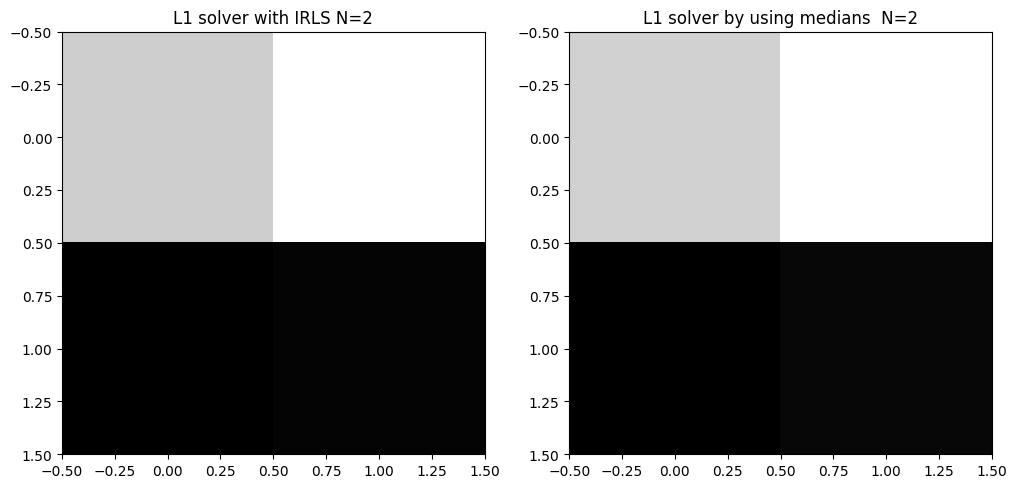

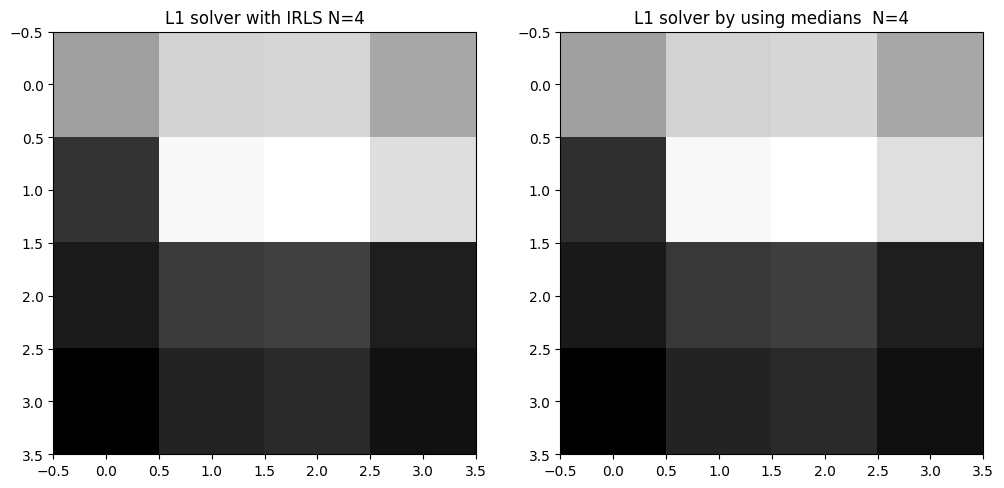

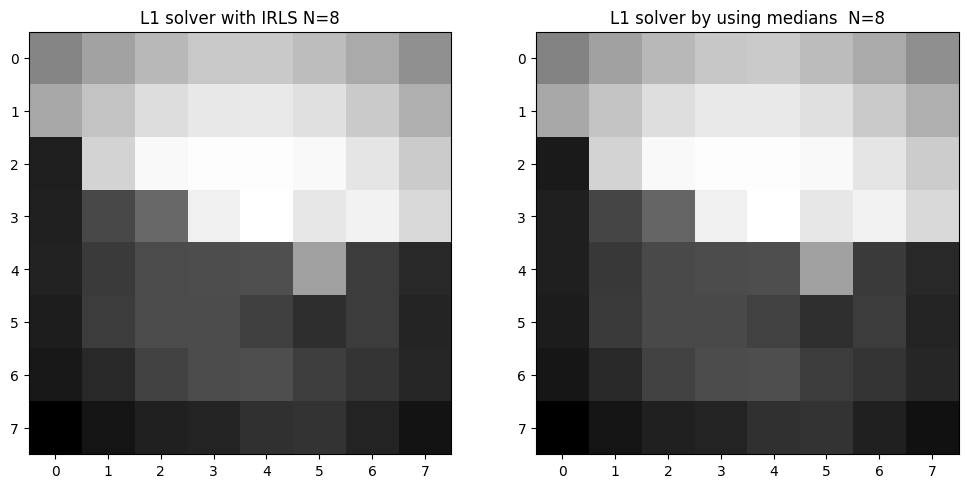

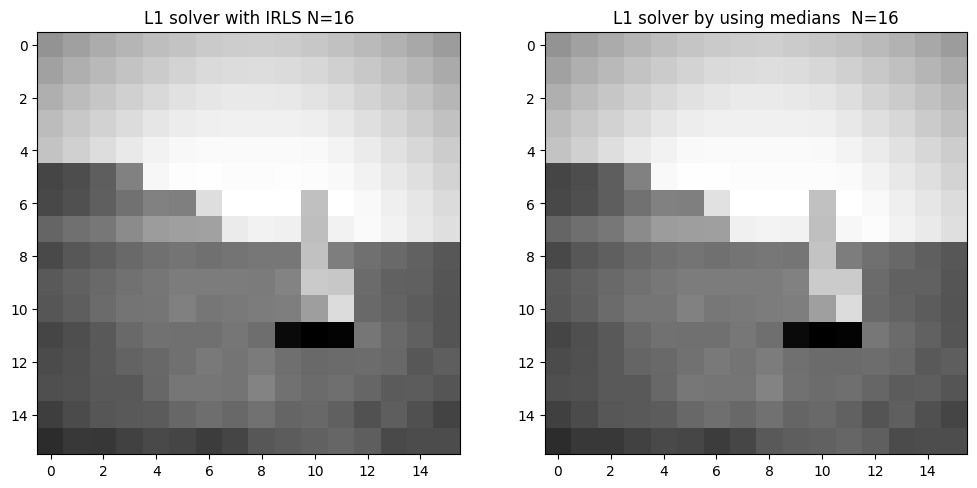

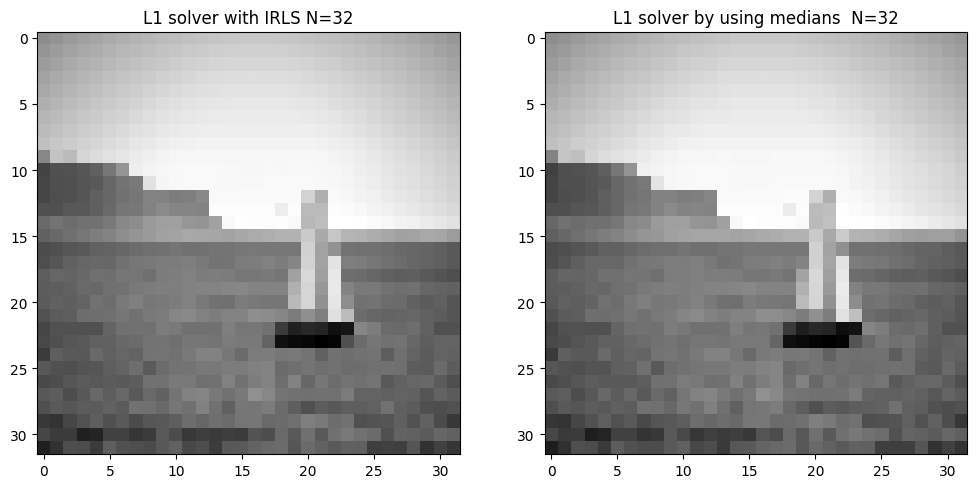

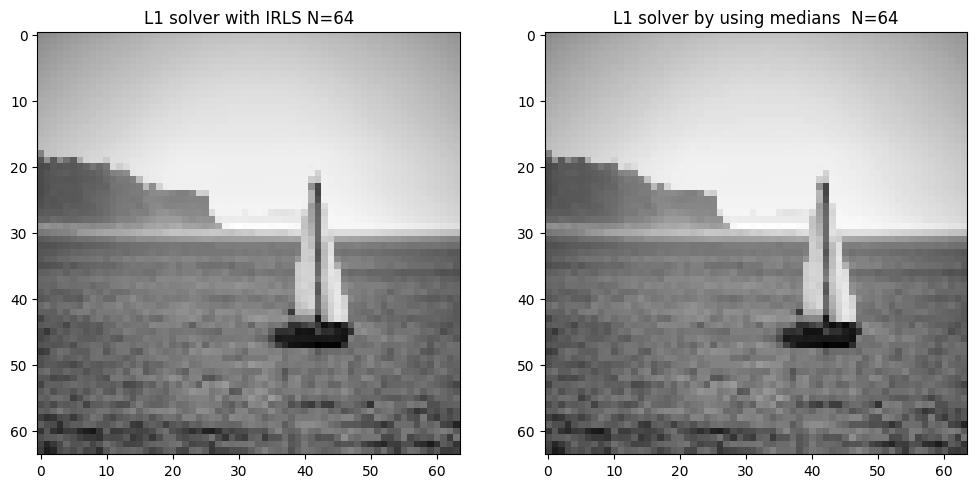

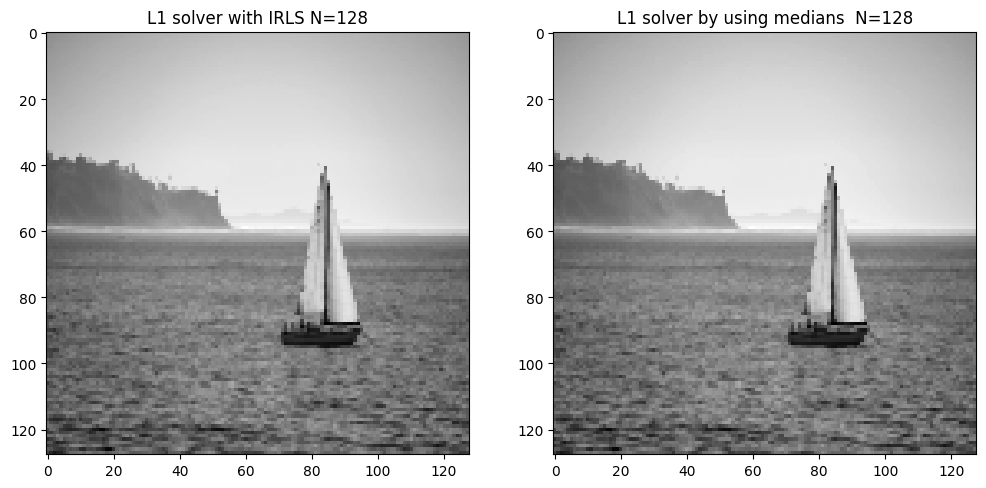

In [97]:
N_s = [2**i for i in range(1, 8)]
epsilon = 1e-3
delta = 1e-5
p = 1

#Create a DataFrame to store the results
df_results_methods = pd.DataFrame(index=["IRLS", "L1 with median"], columns=N_s)

for N in N_s:
    result_approx = irls_on_grids(f, w, N, epsilon, p, delta)
    error_approx = calculate_Lp_error(f, result_approx, N,1)
    result_median = l1_on_grids(f, N)
    error_median = calculate_Lp_error(f, result_median, N,1)
    df_results_methods.loc['IRLS', N] = error_approx
    df_results_methods.loc['L1 with median', N] = error_median
     # Create subplots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"L1 solver with IRLS N={N}")
    plt.imshow(result_approx, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title(f"L1 solver by using medians  N={N}")
    plt.imshow(result_median, cmap='gray')
    plt.show()




In [98]:
#comparing errors
df_results_methods

2         4         8         16        32        64   \
IRLS             0.07726  0.062234  0.051256  0.041459  0.035951  0.030257   
L1 with median  0.077244   0.06221  0.051233   0.04143  0.035914  0.030217   

                     128  
IRLS            0.024492  
L1 with median  0.024456

*Comparison of L1 with Medians Method and the Approximated L1 Solution with IRLS*

1. **Error Comparison:**
   - The median method generally yields smaller errors because the optimal solution for the L1 problem is to approximate the grid with the median.
   - The errors obtained with IRLS are very close to the optimal Mean Absolute Deviation (MAD) error, indicating that the IRLS method approximates the solution quite well.

2. **Visual Comparison:**
   - The IRLS method returns smoother images. This is due to the use of the L2 weighted solver, which calculates the weighted average as the optimal solution at each iteration.
   - As a result, the IRLS method naturally produces smoother approximations.

Overall, the IRLS method performs well in approximating the L1 solution/

**(Q5)Run your algorithm on the same image to compute the approximate  $L^{3/2}$ AND $L^4$ solutions. Comment on your results.**


In [99]:
N_s = [2**i for i in range(5, 9)]
epsilon = 1e-3
delta = 1e-5
df_results_L = pd.DataFrame(index=["L1.5", "L4"], columns=N_s)
f = np.array(image) / 255.0  # Normalize to [0, 1]
w = np.ones_like(f)


32


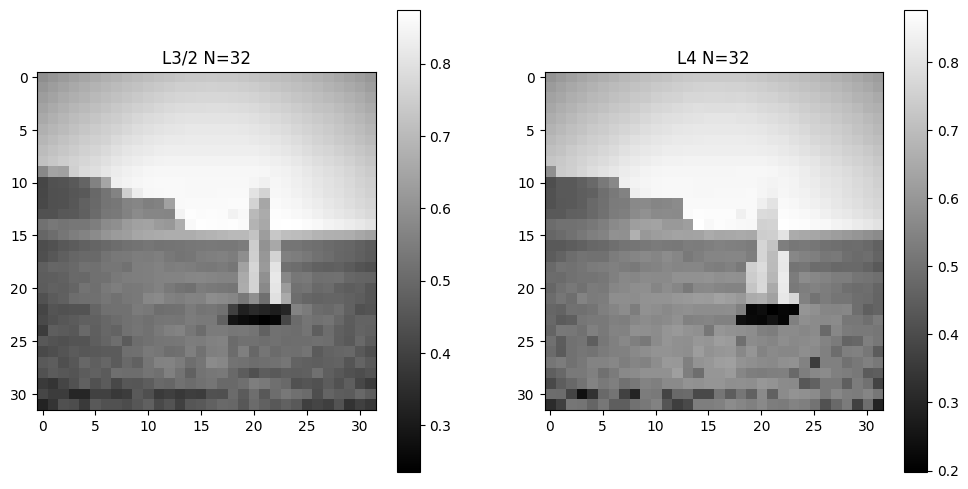

64


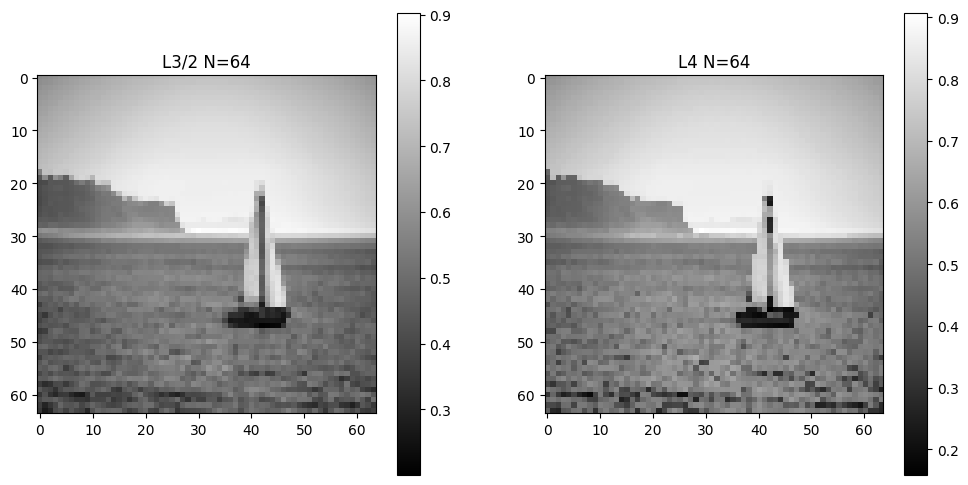

128


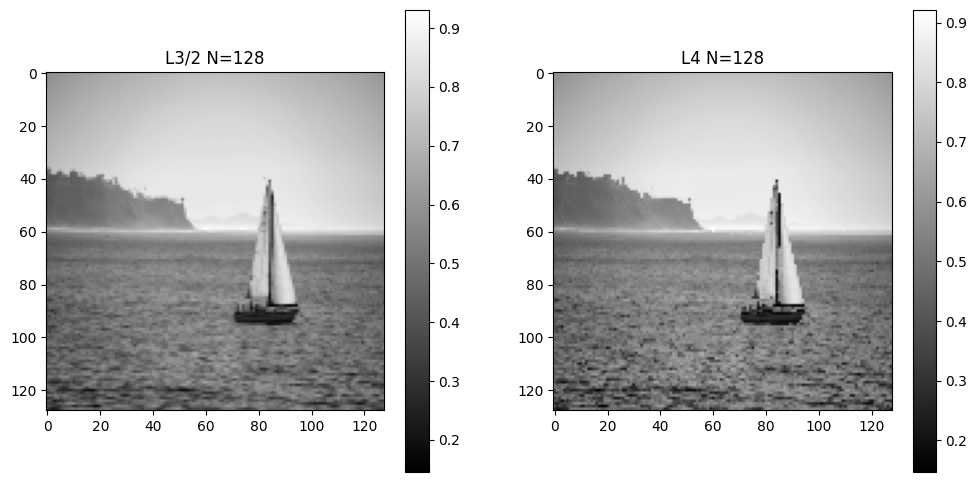

256


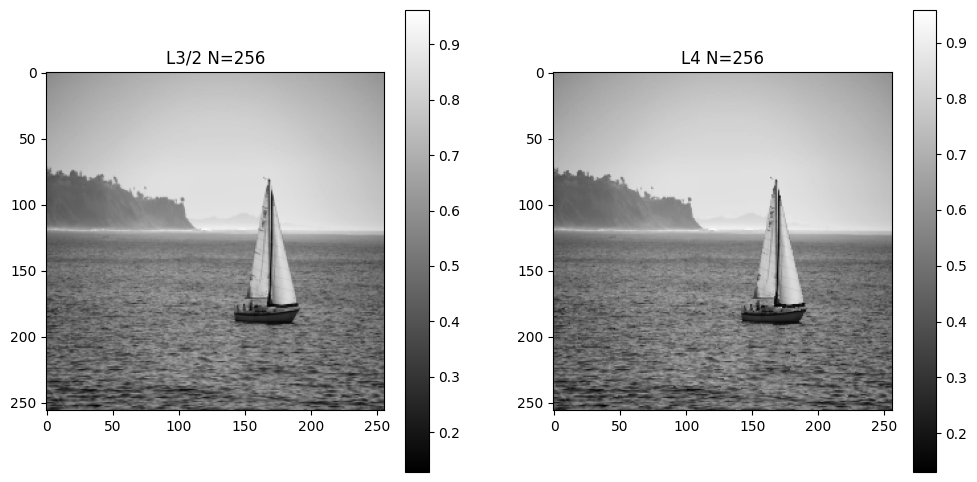

In [100]:
for N in N_s:
    print(N)
    result_l_one_and_half = irls_on_grids(f, w, N, epsilon, 1.5, delta)
    error_l_one_and_half = calculate_Lp_error(f, result_l_one_and_half, N, 1.5)
    df_results_L.loc["L1.5", N] = error_l_one_and_half
    result_l_4 = irls_on_grids(f, w, N, epsilon, 4, delta)
    error_l_4 = calculate_Lp_error(f, result_l_4, N, 4)
    df_results_L.loc["L4", N] = error_l_4

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title(f"L3/2 N={N}")
    plt.imshow(result_l_one_and_half, cmap='gray')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"L4 N={N}")
    plt.imshow(result_l_4, cmap='gray')
    plt.colorbar()

    plt.show()



In [101]:
# Print the DataFrame with the errors
df_results_L



32        64        128       256
L1.5  0.010981  0.008773  0.006634  0.003846
L4    0.000383  0.000217  0.000127  0.000015

**Analysis of $L_{3/2}$ and $L_4$ Norm Approximations**

*Visual Analysis*
1. *Blurriness and Coarseness*:
   - **$L_{3/2}$ Norm**: The image produced with the $L_{3/2}$ norm appears blurrier, especially in regions with gradual changes. This blurriness is due to the $L_{3/2}$ norm's tendency to smooth transitions and spread the approximation over a larger area (i.e., choose a value that will best suit all pixels similiar to $L_2$).
   - **$L_4$ Norm**: The image produced with the $L_4$ norm appears coarser and more pixelated. This coarseness is due to the $L_4$ norm's emphasis on minimizing larger deviations more strongly, which can lead to sharper but less smooth transitions (this metric punishes more on higher deviations so its very sensitive to "outliers" pixels).

*Quantitative Analysis*
- **Metric Differences**:
  We can't compare $L_{3/2}$ and $L_4$ metrics directly since they represent different metrics (it's reasonable that they are different because they measure different errors).
  However, we could say that for both metrics, the error is reduced as $N$ increases, just like we saw before.

*Convergence and Stability*:
   - For $L_4$, the convergence rate was slower, and we had to add a maximum number of iterations since the error continued to change more than the delta for a long time.
   - This might indicate that the IRLS method is less suitable for larger $p$.

